In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wednesday October 10 10:11:42 2023
Creation of Figures

@author: Dr. Olivier Jaubert
"""

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

import numpy as np
import tensorflow as tf
try:
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('running on CPU')
import tensorflow_mri as tfmri
import random
import matplotlib.pyplot as plt
import datetime
import shutil
import tqdm
import glob
import tensorflow_io as tfio
import functools
import h5py

# Local imports (works if you are in project folder)
import utils.preprocessing_natural_videos as preproc_filename_2_kspace
import utils.preprocessing_cartesian_VarNet as preproc_cartesian
import utils.display_function as display_func
from utils.subsample_cartesian import generate_mask
import utils.preprocessing_multicoil_noselect as preproc_radial
import utils.preprocessing_trajectory_gen as preproc_traj

import utils.model_utils as model_utils


#Set seed for all packages
seed_value=1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
;

2023-11-07 16:28:22.673596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 16:28:22.784038: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 16:28:24.933164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 16:28:24.940762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-07 16:28

''

In [2]:
#Configuration
config_preproc=preproc_cartesian.config_base_preproc()
config_preproc['phases']=24
config_preproc['base_resolution']=240

config_natural_images={'base_resolution':config_preproc['base_resolution'],'masking':True,
                        'phases':config_preproc['phases'],
                        'regsnr':[12,22],'sigma_coil':[2,6],'complex_transform':4,
                        'num_coils':[30], 'add_phase':2
                        }
size_natural=[244*2,244*6]
data_folder= 'DatasetFolder/Inter4K/60fps/UHD/'
        
config={'experiment_path': 'Training_folder',
        'data_folder': data_folder,
        'split' : [0.75,0.10,0.15], #train, val, test
        'split_mode': 'noshuffle', #noshuffle or random
        }



In [3]:
acc=14
phases=15
seed_value=7
mask=generate_mask(seed_value,(phases,1,240,240,1),[acc],[8],half_fourier=0.6,mask_type='noreselect')           


In [4]:
# Read files and split data 
train_files=[]
val_files=[]
test_files=[]

file_order=[]
filelist=[]
path_h5_data=os.path.join(config['data_folder'],'*')
for file in tqdm.tqdm(glob.glob(path_h5_data)):
    filelist.append(file)
if config['split_mode'] == 'random':
    sorted_files =random.shuffle(filelist) 
else:
        sorted_files = sorted(filelist,key=lambda x: int(os.path.splitext(os.path.split(x)[-1])[-2]))
        sorted_files = [x for x in sorted_files] 
        list_to_remove=['312.mp4','66.mp4','675.mp4','502.mp4',]
        for bad_element in list_to_remove:
            sorted_files.remove(os.path.join(os.path.split(path_h5_data)[0],bad_element))#this video has frames including only zeros leading to nans
n=692

#n=len(sorted_files)
ntrain=int(config['split'][0]*n)
nval=int(config['split'][1]*n)
ntest=int(np.ceil(config['split'][2]*n))
#print('leftovers:',n-ntrain-nval-ntest)
train_files.append(sorted_files[:ntrain])
val_files.append(sorted_files[ntrain:ntrain+nval])
test_files.append(sorted_files[ntrain+nval:ntrain+nval+ntest])

train_files=np.concatenate(train_files,axis=0)
val_files=np.concatenate(val_files,axis=0)
test_files=np.concatenate(test_files,axis=0)

# Shuffle files.
random.shuffle(train_files)
random.shuffle(val_files)
random.shuffle(test_files)

print('Total/Train/Val/Test:',len(train_files)+len(val_files)+len(test_files),
      '/',len(train_files),'/',len(val_files),'/',len(test_files),'leftovers:',n-ntrain-nval-ntest)

100%|██████████| 1000/1000 [00:00<00:00, 2830164.64it/s]

Total/Train/Val/Test: 692 / 519 / 69 / 104 leftovers: 0


In [5]:
#Util Functions
# For Natural Images
def decode_videos(videofile):
  video = tf.io.read_file(videofile)
  video = tfio.experimental.ffmpeg.decode_video(video,0)
  video=video[:50,...]
  return {'video':video}
def resize_video(video,size=[244*2,244*6]):
  video=video['video']
  video=tf.image.resize(video,size, method='bilinear', preserve_aspect_ratio=True, antialias=False)
  video=tf.cast(tf.clip_by_value(video,0,255),tf.uint8)
  return {'video':tf.ensure_shape(video,(None,)*4)}
# For Cardiac Images
element_spec = {
    '/kspace': tf.TensorSpec(shape=(None,) * 5, dtype=tf.complex64),
}

def _read_hdf5(filename, spec=None):
    """Reads an HDF5 element."""
    io_tensor = tfio.IOTensor.from_hdf5(filename, spec=spec)
    tensors = {k: io_tensor(k).to_tensor() for k in io_tensor.keys}
    return {k: tf.ensure_shape(v, spec[k].shape) for k, v in tensors.items()}

# We need to remove the initial slashes from the keys (e.g. /kspace -> kspace).
def _remove_slashes(structure):
  return {k[1:]: v for k, v in structure.items()}

2023-11-07 16:28:36.825355: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 7464960000 exceeds 10% of free system memory.
2023-11-07 16:28:47.837477: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


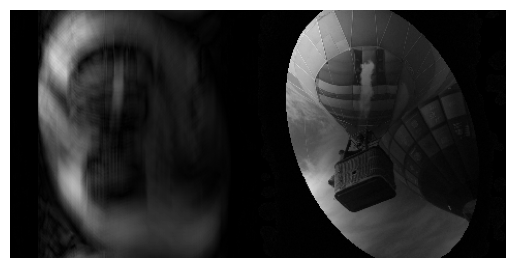

In [6]:
#Define Preprocessing run once to get input shapes
config_natural_images['return_gt']=True
preproc_natural_image=preproc_filename_2_kspace.preprocessing_fn(**config_natural_images)
timepoint=10
preproc_function=preproc_cartesian.preprocessing_fn(**config_preproc)
ncase=4
for ii,element in enumerate(test_files[ncase:ncase+1]):
        video=decode_videos(element)
        video=resize_video(video,size=size_natural)
        kspace=preproc_natural_image(video)
        ds0=tf.data.Dataset.from_tensors(kspace)
        dataset_traj=tf.data.Dataset.from_tensors({'mask':mask})
        ds= tf.data.Dataset.zip((ds0,dataset_traj))
        image = ds.map(lambda image, mask: {'image': image, 'trajectory': mask})
        for element2 in image:
                inputs=preproc_function(element2)
                element3=0
                zfill=tf.complex(inputs[element3][timepoint,...,0],inputs[element3][timepoint,...,1])
                element3=-1
                gt=tf.complex(inputs[element3][timepoint,...,0],inputs[element3][timepoint,...,1])
                plt.figure()
                plt.imshow(np.abs(np.concatenate((zfill,gt),axis=1)),vmin=0,vmax=1,cmap='gray')
                plt.axis('off')
                #inputs,gt=roll_function(inputs_temp,gt_temp)

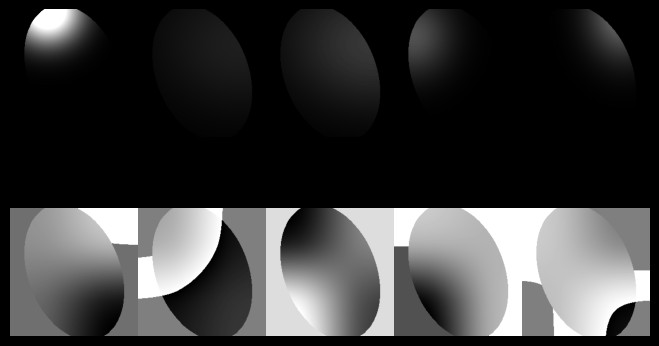

In [7]:
plt.style.use('dark_background')
plt.figure()
for ii in range(5):
    plt.subplot(2,5,ii+1)
    plt.imshow(np.abs(kspace['sensitivities'][ii,:,:]),cmap='gray',vmin=0,vmax=0.5)
    plt.axis('off')
    plt.subplot(2,5,ii+6)
    plt.imshow(np.angle(kspace['sensitivities'][ii,:,:]),cmap='gray')
    plt.axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('Figures/Simulate Coils')

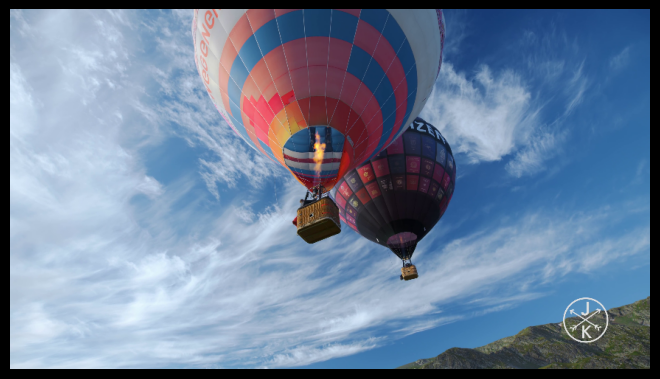

In [8]:
plt.figure()
plt.imshow(video['video'][timepoint,:,:,:],vmin=0,vmax=1,cmap='gray')
plt.axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('Figures/RGBVideo')

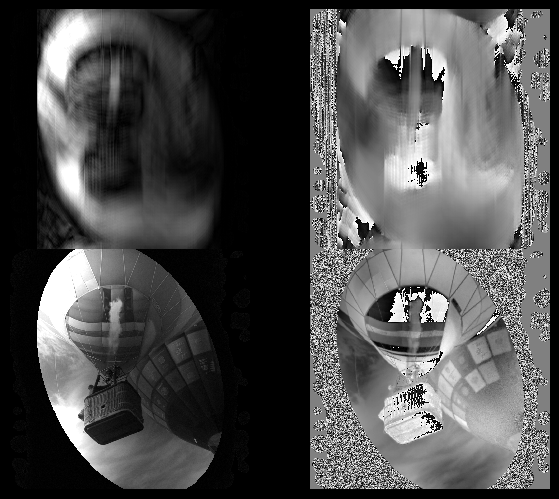

In [9]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(np.abs(np.concatenate((zfill,gt),axis=0)),vmin=0,vmax=0.6,cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(np.angle(np.concatenate((zfill,gt),axis=0)),cmap='gray')
plt.axis('off')
plt.tight_layout(pad=0, w_pad=0, h_pad=0)
plt.savefig('Figures/ZfillGTimageCartesian')

In [10]:
config_traj_spiral=preproc_traj.config_optimized_traj()
config_preproc_spiral=preproc_radial.config_base_preproc()
traj_function=preproc_traj.create_traj_fn(**config_traj_spiral)
preproc_function=preproc_radial.preprocessing_fn(**config_preproc_spiral)
ds0=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds0)
for element in image:
        traj_spiral=element['traj']['traj']
        inputs_spiral,gt_spiral=preproc_function(element)

#Generate Radial
config_preproc_radial=config_preproc_spiral
config_traj_radial=config_traj_spiral
config_traj_radial['phases']=config_preproc['phases']
config_traj_radial['reverse']=True
config_traj_radial['base_resolution']=256
config_preproc_radial['base_resolution']=256
config_traj_radial['radial_spokes']=13
config_traj_radial['ordering']='tiny_half'
traj_function=preproc_traj.create_traj_fn(**config_traj_radial)
preproc_function=preproc_radial.preprocessing_fn(**config_preproc_radial)
ds0=tf.data.Dataset.from_tensors(kspace)
image=traj_function(ds0)
for element in image:
        traj_radial=element['traj']['traj']
        inputs_radial,gt_radial=preproc_function(element)


/usr/local/lib/python3.8/dist-packages/tensorflow_mri/python/ops/traj_ops.py:404: UserWarning: When using tiny golden angle ordering, optimal k-space filling is achieved when the number of views is a member of the generalized Fibonacci sequence: 1, 7, 8, 15, 23, 38, 61, 99, 160, 259..., but the specified number (13) is not a member of this sequence.
  warnings.warn(


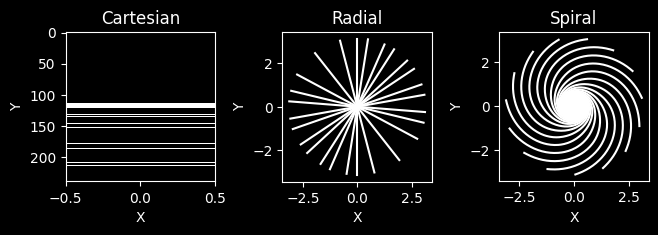

In [11]:
plt.figure()
plt.subplot(1,3,1)
plt.title('Cartesian')
plt.imshow(np.transpose(np.squeeze(mask))[:,1:2],aspect=1/240,interpolation='nearest',cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1,3,2, aspect='equal')
plt.title('Radial')
plt.plot(np.transpose(traj_radial[0,:,:,0]),np.transpose(traj_radial[0,:,:,1]),color='w')
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1,3,3, aspect='equal')
plt.title('Spiral')
plt.plot(np.transpose(traj_spiral[0,:,:,0]),np.transpose(traj_spiral[0,:,:,1]),color='w')
#plt.plot(np.transpose(traj_spiral[1,:,:,0]),np.transpose(traj_spiral[1,:,:,1]),color='w')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout(pad=0.05, w_pad=0.5, h_pad=0)
plt.savefig('Figures/All_Trajectories')

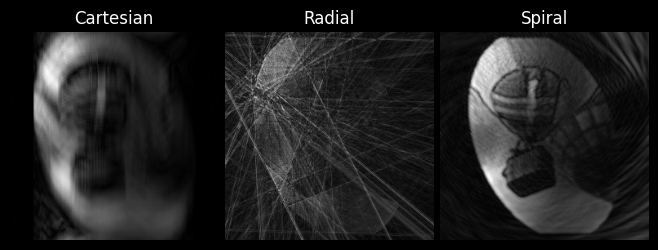

In [12]:
plt.figure()
plt.subplot(1,3,1)
plt.title('Cartesian')
plt.imshow(np.abs(zfill),cmap='gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Radial')
radial_zfill=np.abs(tfmri.combine_coils(tf.complex(inputs_radial[:,:,timepoint,:10],inputs_radial[:,:,timepoint,10:]),coil_axis=-1))
plt.imshow(radial_zfill,cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title('Spiral')
spiral_zfill=np.abs(tfmri.combine_coils(tf.complex(inputs_spiral[:,:,timepoint,:10],inputs_spiral[:,:,timepoint,10:]),coil_axis=-1))
plt.imshow(spiral_zfill,cmap='gray')
plt.axis('off')

plt.tight_layout(pad=0.05, w_pad=0.5, h_pad=0)
plt.savefig('Figures/Zfill_All_Trajectories')

In [34]:
# Load Models and plot reconstructed  

inputs2=[]
for ii,xx in enumerate(inputs):
    inputs2.append(tf.expand_dims(xx,axis=0))
VarNet=model_utils.load_models(inputs2,model_type='VarNet')
VarNet.load_weights('TrainingFolder/Default_VarNet/ckpt/saved_model')

inputs_radial2=[tf.expand_dims(tf.transpose(inputs_radial,[2,0,1,3]),axis=0)]  
MCUNet=model_utils.load_models(inputs_radial2,model_type='3DUNet')
MCUNet.load_weights('TrainingFolder/Default_3DUNet/ckpt/saved_model')

inputs_spiral2=[tf.expand_dims(np.abs(tfmri.combine_coils(tf.complex(inputs_spiral[:,:,:5,:10],inputs_spiral[:,:,:5,10:]),coil_axis=-1)),axis=0)]
FastDVDNet=model_utils.load_models(inputs_spiral2,model_type='FastDVDNet')
FastDVDNet.load_weights('TrainingFolder/Default_FastDVDNet/ckpt/saved_model')


2023-11-07 17:03:45.104629: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open TrainingFolder/Default_VarNet/ckpt/saved_model: FAILED_PRECONDITION: TrainingFolder/Default_VarNet/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-11-07 17:03:45.545965: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open TrainingFolder/Default_3DUNet/ckpt/saved_model: FAILED_PRECONDITION: TrainingFolder/Default_3DUNet/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2023-11-07 17:03:45.792946: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open TrainingFolder/Default_FastDVDNet/ckpt/saved_model: FAILED_PRECONDITION: TrainingFolder/Default_FastDVDNet/ckpt/saved_model; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [40]:
#FastDVDNet recon
output=VarNet(inputs2)[0,...]
output=np.abs(tf.complex(output[...,0],output[...,1]))
output_radial=MCUNet(inputs_radial2[0])[0,:output.shape[0],...,0]

output_spiral=[]
for ii in range(inputs_spiral.shape[-2]-5):
    inputs_spiral2=[tf.expand_dims(np.abs(tfmri.combine_coils(tf.complex(inputs_spiral[:,:,ii:ii+5,:10],inputs_spiral[:,:,ii:ii+5,10:]),coil_axis=-1)),axis=0)]
    output_spiral.append(FastDVDNet(inputs_spiral2[0])[0,...,0])
output_spiral=np.stack(output_spiral,axis=0)[:output.shape[0],...]


(24, 240, 240) (24, 240, 240) (24, 240, 240)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


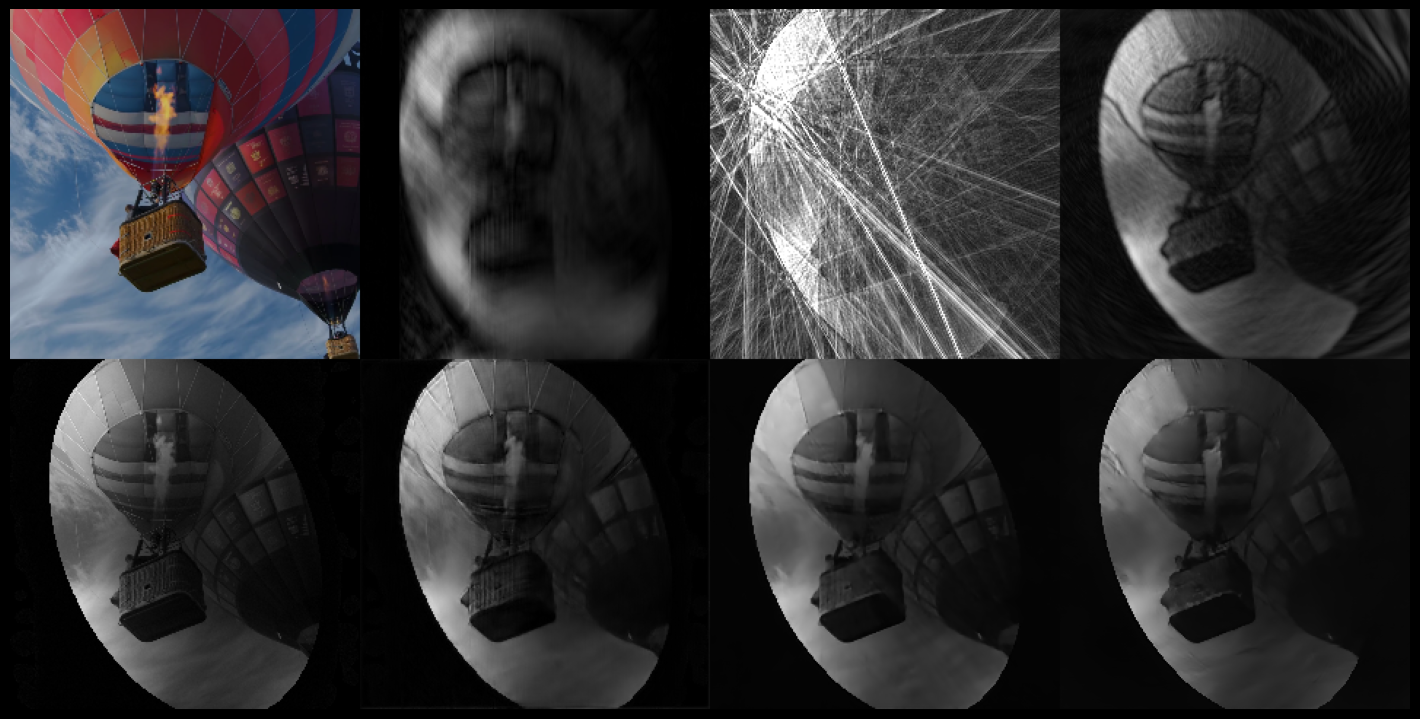

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [45]:
savefile='Figures/VideoInter4K'
#Crop and plot:
output_radial=tfmri.resize_with_crop_or_pad(output_radial,output.shape)
output_spiral=tfmri.resize_with_crop_or_pad(output_spiral,output.shape)
print(output.shape,output_radial.shape,output_spiral.shape)
zfill=np.abs(tf.complex(inputs[0][...,0],inputs[0][...,1]))
gt=np.abs(tf.complex(inputs[-1][...,0],inputs[-1][...,1]))

radial_zfill=np.abs(tfmri.combine_coils(tf.complex(inputs_radial[:,:,:,:10],inputs_radial[:,:,:,10:]),coil_axis=-1))
radial_zfill=np.transpose(radial_zfill,axes=[2,0,1])
radial_zfill=tfmri.resize_with_crop_or_pad(radial_zfill,output.shape)

spiral_zfill=np.abs(tfmri.combine_coils(tf.complex(inputs_spiral[:,:,:,:10],inputs_spiral[:,:,:,10:]),coil_axis=-1))
spiral_zfill=np.transpose(spiral_zfill,axes=[2,0,1])
spiral_zfill=tfmri.resize_with_crop_or_pad(spiral_zfill,output.shape)
vid_rgb=tf.cast(tfmri.resize_with_crop_or_pad(video['video'],output.shape+(3,)),dtype=tf.float32)
zfills=np.tile(np.expand_dims(np.concatenate((zfill,radial_zfill,spiral_zfill),axis=2),axis=-1),reps=[1,1,1,3])
zfills2=np.concatenate((vid_rgb/np.max(vid_rgb)*0.8,zfills),axis=2)
plot_image=np.tile(np.expand_dims(np.concatenate((gt,output,output_radial,output_spiral),axis=2),axis=-1),reps=[1,1,1,3])
plot_image=np.concatenate((zfills2,plot_image),axis=1)
display_func.plotVid(plot_image,axis=0,figsize=(14,7),interval=40,bg_color='k',savepath=savefile)